# Access satellite imagery using Python

Objectives:
- Search public repositories of satellite imagery using Python.
- Inspect the search result metadata.
- Download (a subset of) the assets available for a satellite scene.
- Open the satellite imagery as raster data and setup some raster calculations.
- Save the processed satellite data to disk.

In [1]:
# TODO: add packages to environment
# !pip install pystac-client graphviz

## Search for satellite imagery

### SpatioTemporal Asset Catalog (STAC)

In [2]:
from pystac_client import Client

# Earth-Search STAC endpoint for Open Data collections on AWS
# https://registry.opendata.aws/sentinel-2-l2a-cogs
api_url = "https://earth-search.aws.element84.com/v0"
client = Client.open(api_url)

### Exercise: Explore STAC
Point your web browset to the STAC endpoint https://earth-search.aws.element84.com/v0. By navigating through the links find out which collections and how many scenes are available. Explore the API in order to find out which parameters can be used to search for scenes (you might use the online editor https://editor.swagger.io: select File > Import URL  and add https://earth-search.aws.element84.com/v0/api in the pop up window). 

In [3]:
# collection: Sentinel-2, Level 2A, COGs
collection = "sentinel-s2-l2a-cogs"

In [4]:
# AMS coordinates
lat, lon = 52.37, 4.90  

In [5]:
coords = dict(type="Point", coordinates=(lon, lat))
mysearch = client.search(
    collections=[collection],
    intersects=coords,
    max_items=10,
)

In [6]:
print(mysearch.matched())

612


In [7]:
items = mysearch.get_all_items()
print(len(items))

10


In [8]:
for item in items:
    print(item)

<Item id=S2B_31UFU_20220122_0_L2A>
<Item id=S2A_31UFU_20220120_0_L2A>
<Item id=S2A_31UFU_20220117_0_L2A>
<Item id=S2B_31UFU_20220115_0_L2A>
<Item id=S2B_31UFU_20220112_0_L2A>
<Item id=S2A_31UFU_20220110_0_L2A>
<Item id=S2A_31UFU_20220107_0_L2A>
<Item id=S2B_31UFU_20220105_0_L2A>
<Item id=S2B_31UFU_20220102_0_L2A>
<Item id=S2A_31UFU_20211231_0_L2A>


In [9]:
item = items[0]
item.properties

{'datetime': '2022-01-22T10:46:20Z',
 'platform': 'sentinel-2b',
 'constellation': 'sentinel-2',
 'instruments': ['msi'],
 'gsd': 10,
 'view:off_nadir': 0,
 'proj:epsg': 32631,
 'sentinel:utm_zone': 31,
 'sentinel:latitude_band': 'U',
 'sentinel:grid_square': 'FU',
 'sentinel:sequence': '0',
 'sentinel:product_id': 'S2B_MSIL2A_20220122T104239_N0301_R008_T31UFU_20220122T121827',
 'sentinel:data_coverage': 66.51,
 'eo:cloud_cover': 99.83,
 'sentinel:valid_cloud_cover': True,
 'created': '2022-01-22T16:20:48.994Z',
 'updated': '2022-01-22T16:20:48.994Z'}

### Exercise: Search satellite scenes using filters on metadata
Search for all the available Sentinel-2 assets in the `sentinel-s2-l2a-cogs` collection that satisfy the following conditions: 
- include a provided bounding box (use ±0.05 deg in lat/lon from the point: 52.37N 4.90E);
- have been recorded in 2021;
- have a cloud coverage smaller than 5%.

How many scenes are available? Save the search results in  JSON format.

#### Solution

In [10]:
from shapely.geometry import Point
p = Point(lon, lat)
bbox = p.buffer(0.05).bounds

In [11]:
mysearch = client.search(
    collections=[collection],
    bbox=bbox,
    datetime="2021-01-01/2021-12-31",
    query=["eo:cloud_cover<5"]
)
print(mysearch.matched())

42


In [12]:
items = mysearch.get_all_items()
items.save_object("mysearch.json")

### Access the assets

In [13]:
# List all assets of the first scene
assets = items[-1].assets  
print(assets.keys())

dict_keys(['thumbnail', 'overview', 'info', 'metadata', 'visual', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'AOT', 'WVP', 'SCL'])


In [14]:
# Print minimal asset descriptions
for key, asset in assets.items():
    print(f"{key}: {asset.title}")

thumbnail: Thumbnail
overview: True color image
info: Original JSON metadata
metadata: Original XML metadata
visual: True color image
B01: Band 1 (coastal)
B02: Band 2 (blue)
B03: Band 3 (green)
B04: Band 4 (red)
B05: Band 5
B06: Band 6
B07: Band 7
B08: Band 8 (nir)
B8A: Band 8A
B09: Band 9
B11: Band 11 (swir16)
B12: Band 12 (swir22)
AOT: Aerosol Optical Thickness (AOT)
WVP: Water Vapour (WVP)
SCL: Scene Classification Map (SCL)


In [15]:
# We have access to the asset URLs (e.g., to download them) ...
print(assets["thumbnail"].href)

https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/31/U/FU/2021/1/12/0/preview.jpg


![](https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/31/U/FU/2021/1/12/0/preview.jpg)

In [16]:
import rioxarray

# ... or we can open them directly (and stream content only when necessary)
visual_href = assets["visual"].href
visual = rioxarray.open_rasterio(visual_href)
visual

<xarray.DataArray (band: 3, y: 10980, x: 10980)>
[361681200 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

In [17]:
# clip as example of processing 
visual_clip = visual.rio.clip_box(
    minx=627000, 
    miny=5802000, 
    maxx=631000, 
    maxy=5806000
)

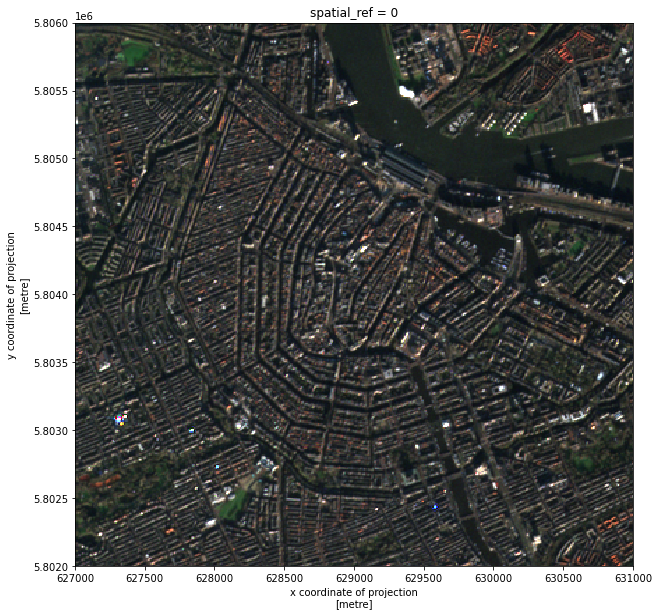

In [18]:
visual_clip.plot.imshow(figsize=(10,10))

In [19]:
visual_clip.rio.crs

CRS.from_epsg(32631)

In [20]:
# save processed image to disk
visual_clip.rio.to_raster("amsterdam_tci.tif", driver="COG")